In [406]:
!pip install --upgrade ultralytics
!pip install --upgrade -U ray[tune]

In [407]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import torch
import random
import yaml

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# import IPython.display as display
from PIL import Image
import cv2
from tabulate import tabulate

from ultralytics import YOLO

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [408]:
!mkdir -p /content/Indoor_Objects_Detection/
!cp -v /content/drive/MyDrive/Dataset/Indoor_Objects_Detection/archive.zip /content/Indoor_Objects_Detection/
!unzip -o /content/drive/MyDrive/Dataset/Indoor_Objects_Detection/archive.zip -d /content/Indoor_Objects_Detection/

In [409]:
# Setting up the device for training (Apple GPU or CPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Running on", device)

Running on cuda


In [410]:
class CFG:
    DEBUG = False # Set to True to make quick experiments
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 42

    # classes
    CLASSES = ['door', 'cabinetDoor','refrigeratorDoor', 'window', 'chair', 'table','cabinet', 'couch', 'openedDoor', 'pole']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 70 # 100
    BATCH_SIZE = 4

    BASE_MODEL = 'yolov9e' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'

    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0

    # paths
    CUSTOM_DATASET_DIR = '/content/Indoor_Objects_Detection/'
    OUTPUT_DIR = '/content/'

In [411]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [412]:
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- door
- cabinetDoor
- refrigeratorDoor
- window
- chair
- table
- cabinet
- couch
- openedDoor
- pole
nc: 10
test: /content/Indoor_Objects_Detection/test
train: /content/Indoor_Objects_Detection/train
val: /content/Indoor_Objects_Detection/valid



In [413]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (1024, 683, 3) 



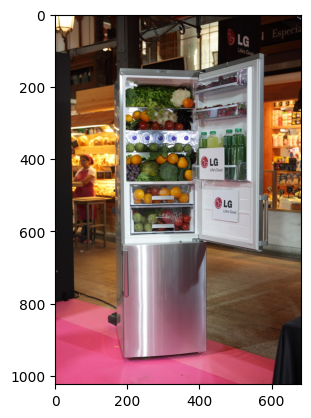

In [414]:
example_image_path = CFG.CUSTOM_DATASET_DIR + 'train/images/b15de360b5a290e0.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

**Display several images**

In [415]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):

    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))

        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


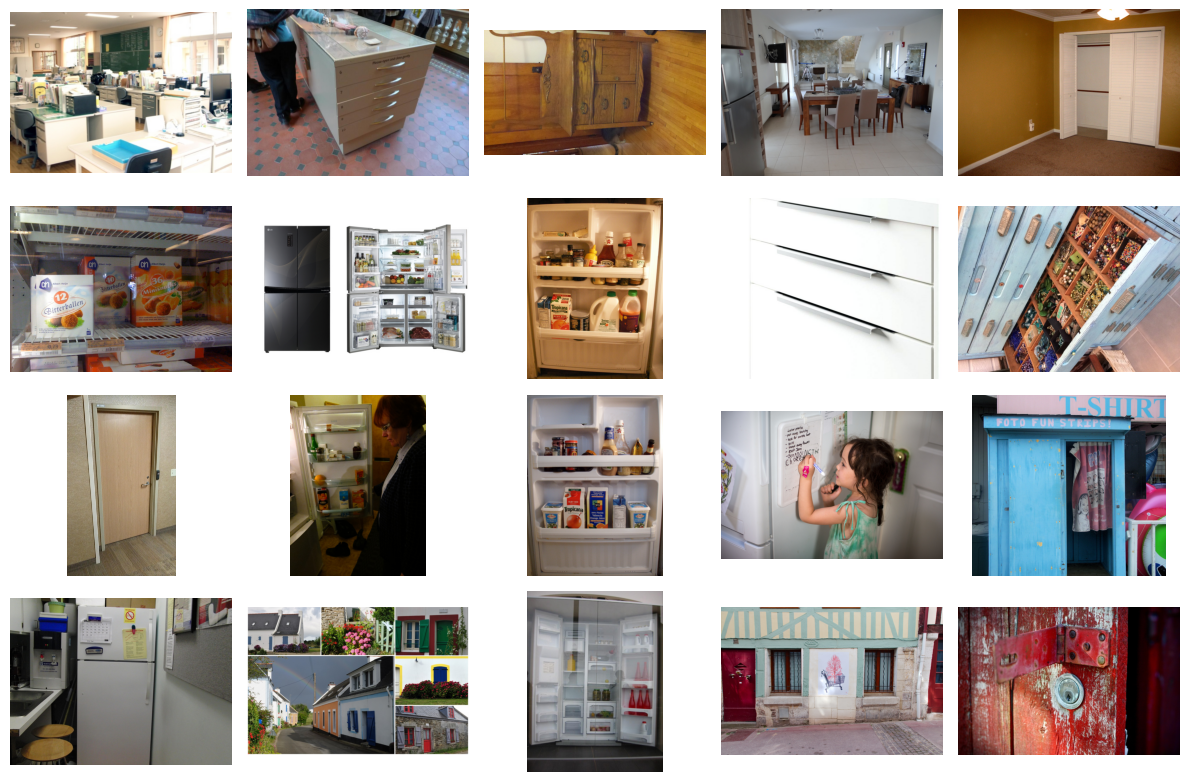

In [416]:
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)

**Store image properties**

In [417]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [418]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 683, 'height': 1024, 'channels': 3, 'dtype': dtype('uint8')}

**Basic statistics**

In [419]:
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
with pd.option_context('display.max_columns', None):
    display(dataset_stats_df)

,Mode,door,cabinetDoor,refrigeratorDoor,window,chair,table,cabinet,couch,openedDoor,pole,Data_Volume
0,train,309,448,332,187,105,165,138,22,68,14,1008
1,valid,63,99,85,39,24,30,28,1,13,4,230
2,test,25,42,1,49,38,41,44,31,18,3,104


**Visualize Class distribution**

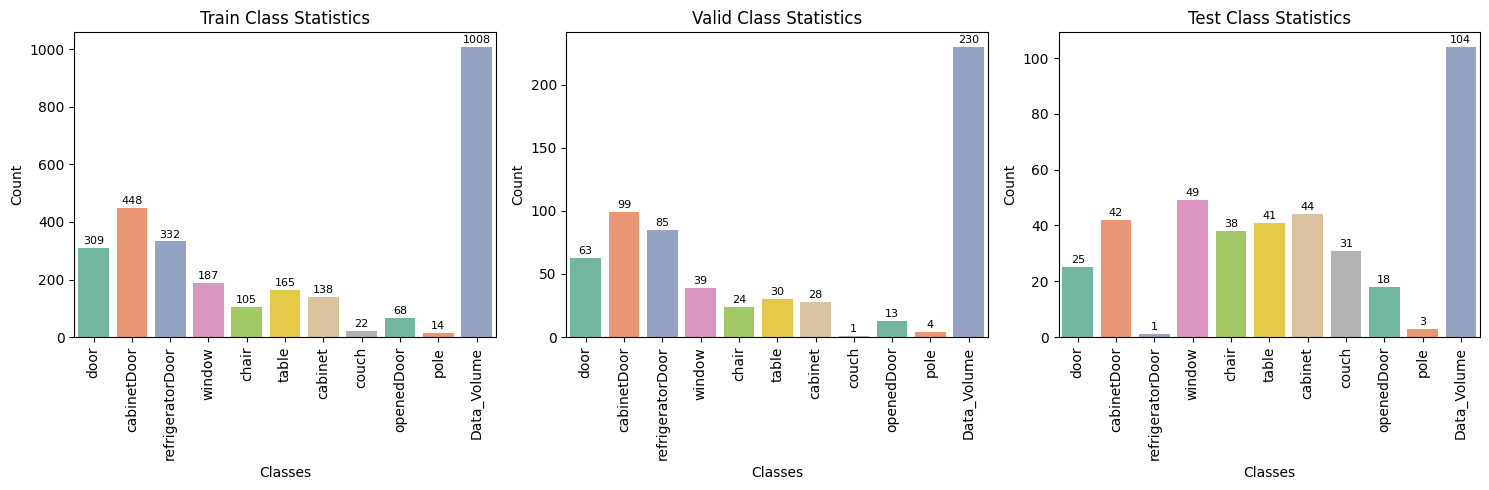

In [420]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    subset = dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode')
    subset = subset.melt(var_name='Classes', value_name='Count')  # Перетворення на довгий формат

    sns.barplot(
        data=subset,
        x='Classes',
        y='Count',
        ax=axes[i],
        palette='Set2'
    )

    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

**Test the model on a selected image, and observe that the pre-trained model correctly identifies the person class**

In [421]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

model.info()

results = model.predict(
    source = example_image_path,
    classes = [0],
    conf = 0.30,
    device = device, # inference with CPU
    imgsz = (img_properties['height'], img_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)

YOLOv9e summary: 1,225 layers, 58,206,592 parameters, 0 gradients, 193.0 GFLOPs

WARNING ⚠️ imgsz=[1024, 683] must be multiple of max stride 32, updating to [1024, 704]
image 1/1 /content/Indoor_Objects_Detection/train/images/b15de360b5a290e0.jpg: 1024x704 1 person, 31.4ms
Speed: 2.8ms preprocess, 31.4ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 704)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (1024, 683, 3) 



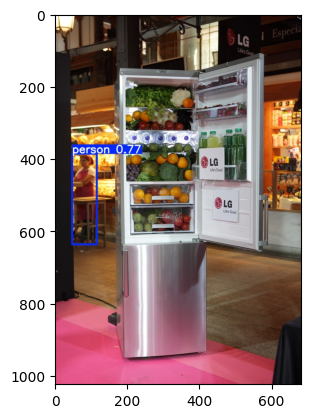

In [422]:
### check predictions with base model
example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'runs/detect/predict/{example_image_inference_output}')

In [423]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov9e.pt
Epochs:  70
Batch:  4


**Model training**

In [424]:
model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,

    val = True,
    amp = True,
    exist_ok = True,
    resume = False,
    device = device,
    verbose = False,
)

engine/trainer: task=detect, mode=train, model=yolov9e.pt, data=/content/data.yaml, epochs=70, time=None, patience=20, batch=4, imgsz=(1024, 683), save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=yolov9e_ppe_css_70_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimi

train: Scanning /content/Indoor_Objects_Detection/train/labels.cache... 1008 images, 120 backgrounds, 0 corrupt: 100%|██████████| 1012/1012 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/Indoor_Objects_Detection/valid/labels.cache... 230 images, 31 backgrounds, 0 corrupt: 100%|██████████| 230/230 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 304 weight(decay=0.0), 316 weight(decay=0.0005), 315 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to runs/detect/yolov9e_ppe_css_70_epochs
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      21.3G      2.677      4.131      2.817         43       1024: 100%|██████████| 253/253 [01:27<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.11it/s]

                   all        230       1289      0.554     0.0791     0.0473     0.0206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70        21G      1.934      2.998      2.077         47       1024: 100%|██████████| 253/253 [01:21<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.58it/s]

                   all        230       1289      0.711      0.104     0.0898      0.045



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      21.3G       1.78      2.684      1.931         32       1024: 100%|██████████| 253/253 [01:18<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.30it/s]

                   all        230       1289      0.506     0.0943     0.0931     0.0479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      21.2G      1.707       2.45      1.861         43       1024: 100%|██████████| 253/253 [01:18<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.69it/s]

                   all        230       1289      0.403      0.185      0.148     0.0747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      21.2G      1.628      2.256       1.77         25       1024: 100%|██████████| 253/253 [01:19<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.68it/s]

                   all        230       1289      0.545      0.186      0.193      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      21.2G       1.59      2.105      1.739         41       1024: 100%|██████████| 253/253 [01:19<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.73it/s]

                   all        230       1289      0.475      0.254      0.186      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      19.6G      1.524      1.967      1.676         31       1024: 100%|██████████| 253/253 [01:19<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.65it/s]

                   all        230       1289      0.514      0.252      0.208      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      21.2G      1.521      1.955      1.689         66       1024: 100%|██████████| 253/253 [01:19<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.60it/s]

                   all        230       1289      0.497      0.297      0.234      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      21.2G      1.483      1.845      1.642         18       1024: 100%|██████████| 253/253 [01:19<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.80it/s]

                   all        230       1289      0.535      0.276      0.237      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      21.1G      1.477      1.785      1.637         20       1024: 100%|██████████| 253/253 [01:19<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.74it/s]

                   all        230       1289      0.571       0.26      0.225      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70        21G       1.45      1.744       1.62         40       1024: 100%|██████████| 253/253 [01:19<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.74it/s]

                   all        230       1289       0.62      0.285       0.27      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      21.3G      1.413      1.656      1.599         36       1024: 100%|██████████| 253/253 [01:19<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.71it/s]

                   all        230       1289      0.639      0.293      0.282      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      21.3G      1.382      1.607      1.566         17       1024: 100%|██████████| 253/253 [01:19<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.79it/s]

                   all        230       1289      0.652      0.285      0.271      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      21.2G      1.409      1.559      1.561         58       1024: 100%|██████████| 253/253 [01:19<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.81it/s]

                   all        230       1289      0.526      0.321      0.302      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      21.2G      1.356      1.551      1.547         55       1024: 100%|██████████| 253/253 [01:18<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.85it/s]

                   all        230       1289      0.517      0.331      0.321      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      21.2G      1.356      1.513       1.55         38       1024: 100%|██████████| 253/253 [01:18<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.89it/s]

                   all        230       1289      0.639      0.324      0.325      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      21.2G      1.342      1.464      1.531         28       1024: 100%|██████████| 253/253 [01:19<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.86it/s]

                   all        230       1289      0.515       0.35      0.302       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      21.2G      1.307      1.435      1.515         56       1024: 100%|██████████| 253/253 [01:19<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.77it/s]

                   all        230       1289      0.533      0.346      0.308      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      21.2G      1.326      1.386      1.504         49       1024: 100%|██████████| 253/253 [01:19<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.82it/s]

                   all        230       1289      0.478      0.346      0.313      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      21.2G      1.291      1.335      1.483         25       1024: 100%|██████████| 253/253 [01:19<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.82it/s]

                   all        230       1289      0.544      0.376      0.341      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      21.2G      1.302      1.348      1.493         73       1024: 100%|██████████| 253/253 [01:19<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.79it/s]

                   all        230       1289      0.363      0.369      0.299      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      21.2G      1.299      1.333      1.486         42       1024: 100%|██████████| 253/253 [01:19<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.84it/s]

                   all        230       1289      0.532      0.325      0.333      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      21.2G      1.257      1.288       1.47         30       1024: 100%|██████████| 253/253 [01:19<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.84it/s]

                   all        230       1289      0.634      0.322      0.332      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      21.2G      1.257      1.257      1.451         22       1024: 100%|██████████| 253/253 [01:19<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.85it/s]

                   all        230       1289      0.469      0.316      0.312      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      21.2G      1.259      1.217      1.457         12       1024: 100%|██████████| 253/253 [01:19<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.86it/s]

                   all        230       1289      0.655      0.338      0.344      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      20.8G      1.221      1.183       1.44         43       1024: 100%|██████████| 253/253 [01:19<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.86it/s]

                   all        230       1289      0.421      0.407      0.356      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70        21G      1.207      1.174      1.434         58       1024: 100%|██████████| 253/253 [01:19<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.89it/s]

                   all        230       1289      0.478      0.336      0.346      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      21.2G      1.219      1.132      1.426         14       1024: 100%|██████████| 253/253 [01:18<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.00it/s]

                   all        230       1289      0.542       0.32      0.361      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      21.2G      1.183      1.127      1.412         37       1024: 100%|██████████| 253/253 [01:18<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.90it/s]

                   all        230       1289      0.407      0.422      0.361      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      21.2G       1.19       1.11      1.403         48       1024: 100%|██████████| 253/253 [01:19<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.85it/s]

                   all        230       1289      0.429      0.347      0.362      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      21.2G      1.167       1.08      1.395         20       1024: 100%|██████████| 253/253 [01:19<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.87it/s]

                   all        230       1289      0.545      0.364      0.356      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      21.2G      1.146      1.015      1.369         48       1024: 100%|██████████| 253/253 [01:19<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.90it/s]

                   all        230       1289      0.657      0.347      0.362      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      21.2G      1.138          1      1.364         69       1024: 100%|██████████| 253/253 [01:19<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.93it/s]

                   all        230       1289      0.658      0.327      0.357      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      21.2G      1.125     0.9937      1.357         53       1024: 100%|██████████| 253/253 [01:19<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.88it/s]

                   all        230       1289      0.359      0.385      0.369      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      21.2G      1.125     0.9774      1.357         46       1024: 100%|██████████| 253/253 [01:19<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.90it/s]

                   all        230       1289      0.664      0.333      0.372      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      21.2G      1.106     0.9707      1.345         34       1024: 100%|██████████| 253/253 [01:19<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.89it/s]

                   all        230       1289      0.447      0.358       0.38      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      21.2G      1.095     0.9177      1.328         44       1024: 100%|██████████| 253/253 [01:19<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.90it/s]

                   all        230       1289      0.517      0.372      0.388      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      21.2G      1.079     0.9307      1.319         40       1024: 100%|██████████| 253/253 [01:19<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.87it/s]

                   all        230       1289      0.362      0.415      0.373      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      21.2G      1.082     0.9124      1.319         37       1024: 100%|██████████| 253/253 [01:19<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.88it/s]

                   all        230       1289      0.342      0.426      0.379      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      21.2G      1.062     0.8931      1.321         49       1024: 100%|██████████| 253/253 [01:18<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.01it/s]

                   all        230       1289      0.438      0.374      0.376      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      21.2G      1.068     0.8999      1.315         48       1024: 100%|██████████| 253/253 [01:18<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.96it/s]

                   all        230       1289      0.464      0.387      0.375      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      21.1G      1.042     0.8434      1.295         42       1024: 100%|██████████| 253/253 [01:19<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.93it/s]

                   all        230       1289      0.377      0.342      0.345      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70        21G      1.039     0.8541      1.286         53       1024: 100%|██████████| 253/253 [01:19<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.91it/s]

                   all        230       1289      0.524      0.333       0.36      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      21.3G      1.017      0.821      1.286         19       1024: 100%|██████████| 253/253 [01:19<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.92it/s]

                   all        230       1289      0.389      0.402      0.371       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70        21G      1.007     0.8154       1.28         49       1024: 100%|██████████| 253/253 [01:19<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.77it/s]

                   all        230       1289       0.55      0.356      0.386       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70        21G      1.006     0.8084      1.285         20       1024: 100%|██████████| 253/253 [01:19<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.88it/s]

                   all        230       1289       0.38       0.42      0.404      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      21.3G     0.9729     0.7716      1.249         59       1024: 100%|██████████| 253/253 [01:19<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.95it/s]

                   all        230       1289      0.507       0.47      0.397       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      21.3G     0.9886     0.7894      1.265          9       1024: 100%|██████████| 253/253 [01:19<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.92it/s]

                   all        230       1289      0.416      0.489      0.412       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      21.3G     0.9718     0.7535      1.245         36       1024: 100%|██████████| 253/253 [01:19<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.84it/s]

                   all        230       1289       0.39      0.413      0.391      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      19.6G     0.9547     0.7447      1.236         52       1024: 100%|██████████| 253/253 [01:19<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.94it/s]

                   all        230       1289      0.432        0.5      0.407      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      21.2G     0.9256     0.7195       1.22         51       1024: 100%|██████████| 253/253 [01:19<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.95it/s]

                   all        230       1289      0.546       0.44      0.394      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      21.2G     0.9482     0.7316      1.233         59       1024: 100%|██████████| 253/253 [01:19<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.98it/s]

                   all        230       1289       0.53      0.462      0.426      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      21.2G     0.9196     0.7204      1.215         58       1024: 100%|██████████| 253/253 [01:18<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.95it/s]

                   all        230       1289      0.499      0.356        0.4      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      21.2G     0.9141     0.6836      1.214         29       1024: 100%|██████████| 253/253 [01:18<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.01it/s]

                   all        230       1289      0.476      0.401      0.388      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      21.2G     0.9174     0.6889       1.21         42       1024: 100%|██████████| 253/253 [01:18<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.99it/s]

                   all        230       1289      0.415      0.442      0.396      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      21.2G     0.9026     0.6564      1.195         36       1024: 100%|██████████| 253/253 [01:18<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.94it/s]

                   all        230       1289      0.474      0.477      0.418      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      21.2G     0.8787     0.6556      1.191         24       1024: 100%|██████████| 253/253 [01:17<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.03it/s]

                   all        230       1289      0.477      0.402      0.409      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70        21G     0.8713     0.6224      1.181         25       1024: 100%|██████████| 253/253 [01:17<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.99it/s]

                   all        230       1289      0.501      0.367      0.414      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70        21G     0.8674     0.6396      1.186         16       1024: 100%|██████████| 253/253 [01:18<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.97it/s]

                   all        230       1289      0.412      0.504      0.402      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      21.2G     0.8581     0.6396      1.186         23       1024: 100%|██████████| 253/253 [01:17<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.96it/s]

                   all        230       1289      0.452      0.469      0.393       0.23


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      21.2G     0.8248     0.5353      1.158         24       1024: 100%|██████████| 253/253 [01:18<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.94it/s]

                   all        230       1289      0.567      0.439      0.428      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      21.2G     0.8029     0.5221      1.132         15       1024: 100%|██████████| 253/253 [01:17<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.88it/s]

                   all        230       1289      0.456      0.505      0.419      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      21.2G     0.8019     0.5272      1.139         31       1024: 100%|██████████| 253/253 [01:18<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.01it/s]

                   all        230       1289      0.564      0.435      0.427       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      19.6G     0.7774     0.4886      1.127          6       1024: 100%|██████████| 253/253 [01:17<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.98it/s]

                   all        230       1289      0.477      0.485        0.4      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      21.2G     0.7692     0.4961      1.102         11       1024: 100%|██████████| 253/253 [01:17<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.98it/s]

                   all        230       1289      0.426      0.517      0.394      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      21.2G     0.7778     0.4926      1.126         10       1024: 100%|██████████| 253/253 [01:17<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.99it/s]

                   all        230       1289      0.562      0.438      0.423       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      21.2G     0.7391     0.6135      1.105         21       1024: 100%|██████████| 253/253 [01:17<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.01it/s]

                   all        230       1289      0.465       0.52      0.433      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      21.2G     0.7437     0.4595      1.104         69       1024: 100%|██████████| 253/253 [01:17<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.95it/s]

                   all        230       1289       0.43      0.519      0.432      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      21.2G     0.7433     0.4593        1.1         27       1024: 100%|██████████| 253/253 [01:18<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.97it/s]

                   all        230       1289      0.536      0.465      0.439      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      21.2G     0.7238     0.4462      1.094         13       1024: 100%|██████████| 253/253 [01:18<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  7.01it/s]

                   all        230       1289      0.492      0.487       0.44      0.252



70 epochs completed in 1.684 hours.
Optimizer stripped from runs/detect/yolov9e_ppe_css_70_epochs/weights/last.pt, 109.0MB
Optimizer stripped from runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt, 109.0MB

Validating runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt...
Ultralytics 8.3.13 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv9e summary (fused): 705 layers, 53,210,286 parameters, 0 gradients, 169.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:04<00:00,  6.02it/s]


                   all        230       1289      0.538      0.465      0.439      0.254
Speed: 0.3ms preprocess, 14.3ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/yolov9e_ppe_css_70_epochs


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a98c76c1ff0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [425]:
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics 8.3.13 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
WARNING ⚠️ imgsz=[1024, 683] must be multiple of max stride 32, updating to [1024, 704]
YOLOv9e summary (fused): 705 layers, 53,210,286 parameters, 0 gradients, 169.5 GFLOPs

PyTorch: starting from 'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt' with input shape (1, 3, 1024, 704) BCHW and output shape(s) (1, 14, 14784) (103.9 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: export success ✅ 6.0s, saved as 'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx' (203.5 MB)

Export complete (10.5s)
Results saved to /content/runs/detect/yolov9e_ppe_css_70_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx imgsz=1024,704  
Validate:        yolo val task=detect model=runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx imgsz=1024,704 data=/content/data.yaml  WARNING ⚠️ non-PyTorch val requires square images, 'imgsz=[1024,

'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx'

In [426]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['/content/runs/detect/yolov9e_ppe_css_70_epochs/PR_curve.png',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/P_curve.png',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/F1_curve.png',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/results.png',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/R_curve.png',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix.png',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix_normalized.png',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/labels_correlogram.jpg',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg']

/content/runs/detect/yolov9e_ppe_css_70_epochs/F1_curve.png


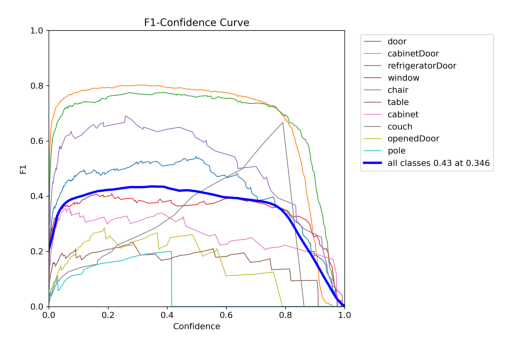



/content/runs/detect/yolov9e_ppe_css_70_epochs/PR_curve.png


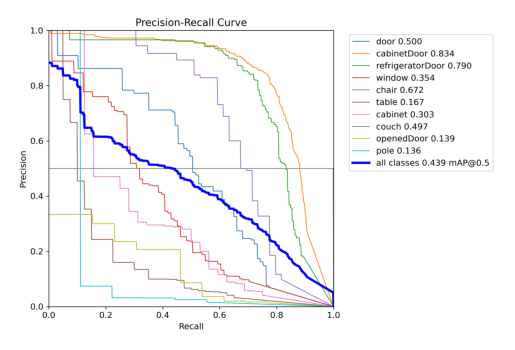



/content/runs/detect/yolov9e_ppe_css_70_epochs/P_curve.png


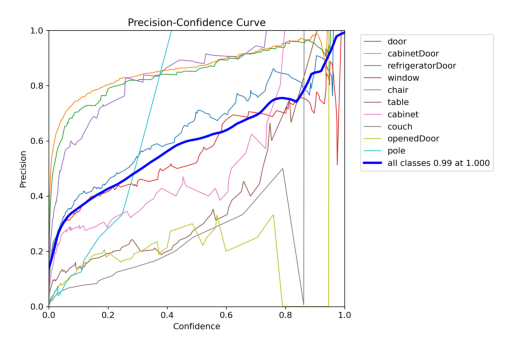



/content/runs/detect/yolov9e_ppe_css_70_epochs/R_curve.png


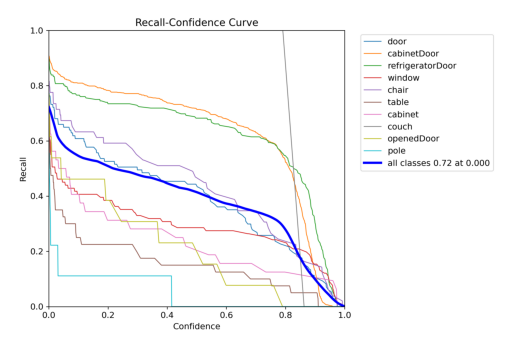



/content/runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix.png


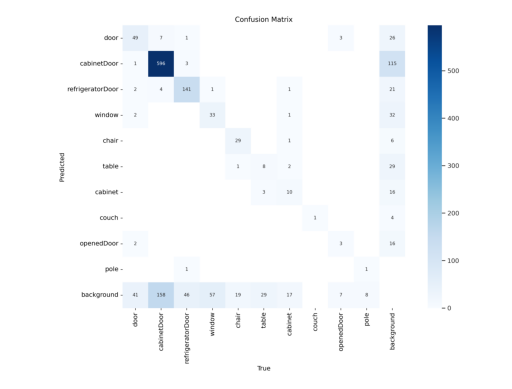



/content/runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix_normalized.png


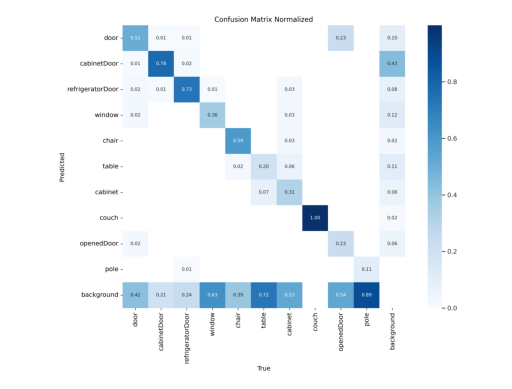



/content/runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg


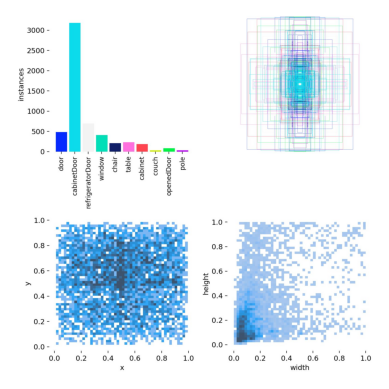



/content/runs/detect/yolov9e_ppe_css_70_epochs/labels_correlogram.jpg


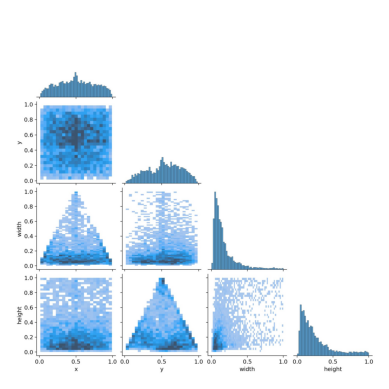



/content/runs/detect/yolov9e_ppe_css_70_epochs/results.png


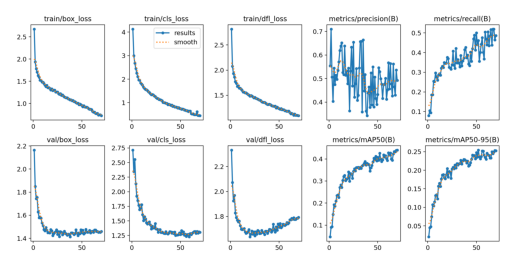

In [427]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')


In [428]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,111.981,2.67712,4.13100,2.81659,0.55386,0.07906,0.04726,0.02058,2.16427,2.71420,2.33143,0.000237,0.000237,0.000237
1,2,200.914,1.93392,2.99751,2.07679,0.71053,0.10441,0.08979,0.04502,1.85055,2.34670,2.07283,0.000468,0.000468,0.000468
2,3,287.293,1.77991,2.68430,1.93072,0.50612,0.09430,0.09313,0.04792,1.74411,2.55342,1.92510,0.000693,0.000693,0.000693
3,4,372.738,1.70722,2.45040,1.86084,0.40295,0.18523,0.14803,0.07469,1.75508,2.13843,1.96899,0.000684,0.000684,0.000684
4,5,459.625,1.62792,2.25649,1.77017,0.54457,0.18580,0.19307,0.10732,1.62828,1.92590,1.82843,0.000674,0.000674,0.000674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,66,5719.580,0.77784,0.49265,1.12612,0.56168,0.43811,0.42266,0.25008,1.45969,1.28729,1.77623,0.000058,0.000058,0.000058
66,67,5804.520,0.73914,0.61346,1.10473,0.46517,0.52000,0.43339,0.24480,1.45153,1.32092,1.77642,0.000048,0.000048,0.000048
67,68,5889.200,0.74366,0.45952,1.10430,0.43007,0.51939,0.43204,0.24948,1.45434,1.29037,1.78482,0.000037,0.000037,0.000037
68,69,5974.150,0.74331,0.45928,1.09981,0.53609,0.46503,0.43861,0.25344,1.45259,1.31104,1.78734,0.000027,0.000027,0.000027


In [429]:
data = [
    ['Training Box Loss', f"{df['train/box_loss'].min():.5f}", df['train/box_loss'].argmin() + 1],
    ['Validation Box Loss', f"{df['val/box_loss'].min():.5f}", df['val/box_loss'].argmin() + 1],
    ['Training Cls Loss', f"{df['train/cls_loss'].min():.5f}", df['train/cls_loss'].argmin() + 1],
    ['Validation Cls Loss', f"{df['val/cls_loss'].min():.5f}", df['val/cls_loss'].argmin() + 1],
    ['Training DFL Loss', f"{df['train/dfl_loss'].min():.5f}", df['train/dfl_loss'].argmin() + 1],
    ['Validation DFL Loss', f"{df['val/dfl_loss'].min():.5f}", df['val/dfl_loss'].argmin() + 1]
]

headers = ["Metric", "Loss", "Epoch"]

print(tabulate(data, headers=headers, tablefmt="grid"))

+---------------------+---------+---------+
| Metric              |    Loss |   Epoch |
+=====================+=========+=========+
| Training Box Loss   | 0.72383 |      70 |
+---------------------+---------+---------+
| Validation Box Loss | 1.41327 |      38 |
+---------------------+---------+---------+
| Training Cls Loss   | 0.44621 |      70 |
+---------------------+---------+---------+
| Validation Cls Loss | 1.22789 |      59 |
+---------------------+---------+---------+
| Training DFL Loss   | 1.09384 |      70 |
+---------------------+---------+---------+
| Validation DFL Loss | 1.63767 |      20 |
+---------------------+---------+---------+


**Training and Validation Loss Metrics Visualization**

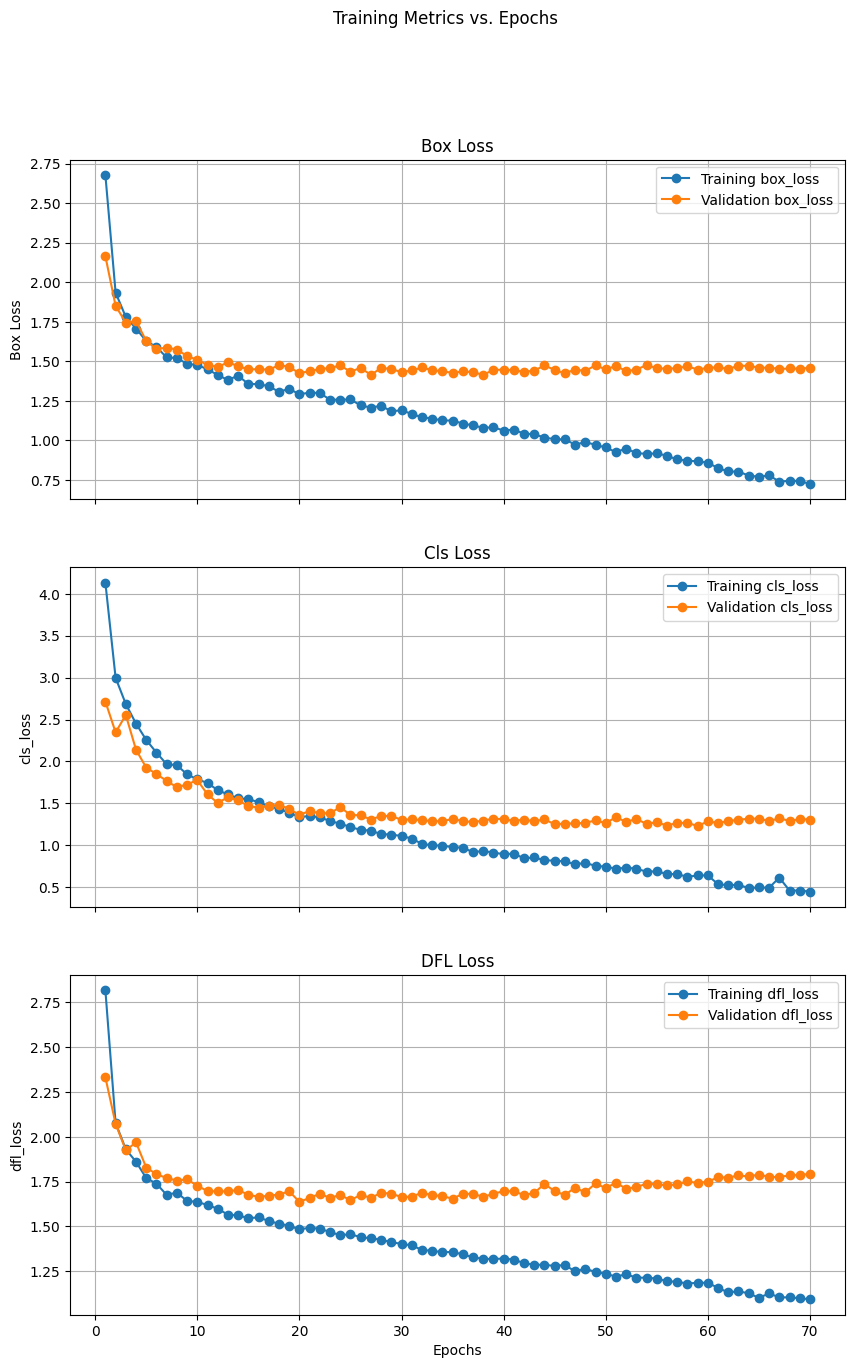

In [430]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()


**Validation results**

In [431]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

In [432]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

/content/runs/detect/yolov9e_ppe_css_70_epochs/val_batch0_labels.jpg


/content/runs/detect/yolov9e_ppe_css_70_epochs/val_batch0_labels.jpg


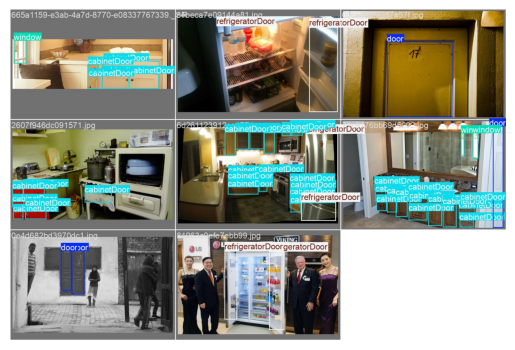

In [433]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)

**Model Validation and Class-wise Performance Metrics Analysis**

In [434]:
# Model validation.
results = model.val(
    data=os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),
    device=device,
    verbose=True
)


YOLOv9e summary (fused): 705 layers, 53,210,286 parameters, 0 gradients, 169.5 GFLOPs


val: Scanning /content/Indoor_Objects_Detection/valid/labels.cache... 230 images, 31 backgrounds, 0 corrupt: 100%|██████████| 230/230 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.54it/s]


                   all        230       1289      0.512      0.471      0.437      0.253
                  door         63         97      0.586      0.495      0.491      0.315
           cabinetDoor         99        765      0.841      0.765      0.833      0.479
      refrigeratorDoor         85        192      0.827      0.724       0.79      0.549
                window         39         91      0.455      0.319      0.352      0.197
                 chair         24         49      0.838      0.528       0.67      0.377
                 table         30         40      0.202      0.175      0.161     0.0765
               cabinet         28         32       0.37      0.281      0.305      0.207
                 couch          1          1      0.152          1      0.497      0.189
            openedDoor         13         13      0.207      0.308      0.134     0.0568
                  pole          4          9      0.639      0.111      0.137     0.0802
Speed: 0.4ms preproce

In [435]:
# Number of classes.
nc = results.box.nc

# Get precision, recall and F1-score for each class.
class_precision = results.box.p  # Accuracy for each class.
class_recall = results.box.r     # Completeness for each class.
class_f1_score = results.box.f1  # F1-score for each class.

# Getting AP for each class at IoU 0.5 and 0.5-0.95.
class_ap50 = results.box.ap50  # AP for each class at IoU 0.5
class_ap = results.box.ap      # AP for each class at IoU 0.5:0.95

# Create a table to display metrics for each class
performance_data = {
    'Class': CFG.CLASSES,
    'Precision': class_precision,
    'Recall': class_recall,
    'F1-Score': class_f1_score,
    'AP@0.5': class_ap50,
    'AP@0.5:0.95': class_ap
}

performance_df = pd.DataFrame(performance_data)

# Print results for skin class
print("\nClass-wise Performance Metrics:")
print(performance_df)

# Determining the best and worst classes by F1 score
best_class = performance_df.iloc[performance_df['F1-Score'].idxmax()]['Class']
worst_class = performance_df.iloc[performance_df['F1-Score'].idxmin()]['Class']

print(f"\nBest performing class: {best_class}")
print(f"Worst performing class: {worst_class}")


Class-wise Performance Metrics:
              Class  Precision    Recall  F1-Score    AP@0.5  AP@0.5:0.95
0              door   0.585705  0.494845  0.536455  0.491197     0.314965
1       cabinetDoor   0.841468  0.764706  0.801253  0.832558     0.479105
2  refrigeratorDoor   0.826973  0.723958  0.772045  0.789585     0.549093
3            window   0.455142  0.318681  0.374880  0.352134     0.197086
4             chair   0.838027  0.528021  0.647848  0.670009     0.377449
5             table   0.202228  0.175000  0.187631  0.160586     0.076542
6           cabinet   0.369827  0.281250  0.319513  0.304994     0.207252
7             couch   0.152052  1.000000  0.263968  0.497500     0.189050
8        openedDoor   0.207347  0.307692  0.247745  0.134386     0.056822
9              pole   0.639105  0.111111  0.189310  0.136725     0.080183

Best performing class: cabinetDoor
Worst performing class: table


**1. Детальний аналіз отриманих результатів**

*Пояснення, чому модель могла не досягти очікуваних показників:*

- Низький показник mAP (mean Average Precision): Найвищий mAP@0.5 для класів становить 0.832, але загальний mAP@0.5-0.95 становить лише 0.253. Це свідчить про те, що модель добре працює при точному налаштуванні (IoU = 0.5), але менш ефективна при більш жорстких вимогах (IoU до 0.95).
- Нерівномірний розподіл об’єктів: Різна кількість прикладів для різних класів може впливати на продуктивність. Наприклад, клас “couch” містить лише один об’єкт, що значно обмежує модель в навчанні на цьому класі.
- Погана узгодженість метрик: Наприклад, клас “pole” має високу точність (Precision = 0.639), але дуже низьку повноту (Recall = 0.111). Це означає, що модель ідентифікує об’єкти цього класу, але пропускає багато з них, що знижує загальну якість.

*Обмеження даних або обраного підходу:*

- Дисбаланс класів: У вас є класи, як-от “couch” або “pole”, з дуже малою кількістю прикладів, що ускладнює їх точне розпізнавання моделлю.
- Наявність фонових зображень: Є 31 фонове зображення (без об’єктів), що може ускладнювати навчання моделі та впливати на точність розпізнавання.
- Недостатня кількість даних для тренування: Модель може бути обмежена через недостатню кількість даних для деяких класів, що призводить до низької продуктивності для деяких об’єктів, таких як “table” і “openedDoor”.

**2. Критична оцінка архітектури моделі**

*Чому обрана саме така структура нейронної мережі:*

- Використання YOLOv9e: Вибір цієї моделі обумовлений її збалансованістю між точністю та швидкістю. YOLOv9e – більш просунута версія, яка може ефективно працювати з великими та складними датасетами, зберігаючи при цьому високу продуктивність.

*Потенційні недоліки архітектури:*

- Можлива недостатня глибина моделі: Якщо архітектура не містить достатньої кількості шарів, це може призвести до втрати здатності моделі навчатися складним взаємозв’язкам у даних.
- Фіксована кількість параметрів: У моделі використовується 705 шарів і 53 мільйони параметрів, що є фіксованою архітектурою. Якщо об’єкти мають дуже різноманітну форму або розміри, може знадобитися гнучкіша модель або більше параметрів.
- Можливе перенавчання: Висока продуктивність на тренувальних даних та низька на валідаційних (наприклад, високі значення F1-score для “couch”, але низькі значення на валідації) можуть свідчити про перенавчання.

**3. Шляхи покращення**

*Ідеї щодо оптимізації моделі:*

- Аугментація даних: Додавання аугментації даних (зміна масштабу, повороти, відображення) може допомогти моделі краще навчитися розпізнавати об’єкти, які зустрічаються в різних положеннях або при різних умовах освітлення.
- Збалансування класів: Використання технік збалансування класів, як-от oversampling для малопредставлених класів або підсистема класів, може покращити точність для менш популярних об’єктів.
- Оптимізація гіперпараметрів: Підбір оптимальних гіперпараметрів, таких як швидкість навчання або кількість епох, може покращити результати. Наприклад, варто збільшити кількість епох, щоб модель могла краще навчитися.

*Альтернативні підходи:*

- Інші архітектури: Альтернативою може бути використання більш глибоких або складніших архітектур, таких як EfficientDet або Detectron2, які можуть дати кращі результати на складних об’єктах.
- Fine-tuning на більшому датасеті: Якщо є можливість, можна виконати попереднє тренування моделі на більшому датасеті, а потім використовувати fine-tuning на вашому датасеті. Це допоможе моделі краще навчитися і поліпшити результати.

**Висновок:**

- Основною причиною низької продуктивності є дисбаланс класів і недостатня кількість даних для деяких об’єктів. Аугментація даних і збалансування класів можуть значно покращити результати.
- Архітектура YOLOv9e добре підходить для реального часу, але, можливо, варто спробувати інші архітектури для кращої продуктивності в складних умовах.